# Comparing the Efficacy of the Exemplar and Prototype Models for Predicting Color Categorization Across Languages

COG260 Research Project 2023

Gabriel Guralnick and Elizabeth Li

## Demos for analyzing World Color Survey (WCS)

COG 260: Data, Computation, and The Mind (Yang Xu)

Data source: http://www1.icsi.berkeley.edu/wcs/data.html

______________________________________________

Import helper function file for WCS data analysis.

In [1]:
from wcs_helper_functions import *

Import relevant Python libraries.

In [2]:
import numpy as np
from scipy import stats
from random import random
from collections import defaultdict
%matplotlib inline

### Demo 1: Import stimulus (color chip) information in [Munsell space](https://en.wikipedia.org/wiki/Munsell_color_system)

> Stimuli were 330 color chips in Munsell space, each defined along lightness and hue dimensions.

> Each color chip has an index _(from 1 to 330)_ and a coordinate (lightness *(alphabet)*, hue *(integer)*).

In the following section, you will learn how to convert from **(a) index to coordinate** and **(b) coordinate to index**.

______________________________________________

Load chip information in Munsell space. 

`munsellInfo` is a 2-element tuple with dictionary elements.

In [3]:
munsellInfo = readChipData('./WCS_data_core/chip.txt')
#munsellInfo

#### (a) Index &rarr; Coordinate

Access the second dictionary in `munsellInfo`.

In [4]:
indexCoord = munsellInfo[1]

`indexCoord` is a dictionary with **index _(key)_ &rarr; coordinate _(value)_** pairs. For example, to retrieve the Munsell coordinate _(lightness, hue)_ for chip with numerical index 1:

In [5]:
print(indexCoord[1])

('E', '29')


You can also uncomment the following to display full stimulus information (long).

In [6]:
# print(indexCoord)

#### (b) Coordinate &rarr; Index

Access the first dictionary in `munsellInfo`.

In [7]:
coordIndex = munsellInfo[0]

`coordIndex` is a dictionary with **coordinate _(key)_ &rarr; index _(value)_** pairs. For example, to access numerical index for the color chip at Munsell coordinate _(D, 11)_:

In [8]:
print(coordIndex['D11'])

258


You can also uncomment the following to display full stimulus information (long).

In [9]:
# print(coordIndex)

### Demo 2: Import stimulus information in [CIELAB space](https://en.wikipedia.org/wiki/Lab_color_space)

> Each of the 330 stimuli can also be mapped to the 3D CIELAB space, where the dimensions are `l` _(lightness)_, `a`, & `b` _(color opponency)_.

> CIELAB Coordinates have a **one-to-one** correspondence with Munsell index, which ranges from 1 to 330.

______________________________________________

Load chip coordinates in CIELAB. 

`cielabCoord` is a dictionary with **index _(key)_ &rarr; CIELAB Coordinate _(value)_** pairs.

In [10]:
cielabCoord = readClabData('./WCS_data_core/cnum-vhcm-lab-new.txt')

For example, to obtain the CIELAB coordinates for chip with numerical index 1:

In [11]:
print(cielabCoord[1])

('61.70', '-4.52', '-39.18')


### Demo 3: Import color naming data
    
> Each of the 330 color chips was named by speakers of 110 different languages.

______________________________________________

Load naming data. 

`namingData` is a hierarchical dictionary organized as follows:

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; chip index _(1 - 330)_ &rarr; color term**

In [12]:
namingData = readNamingData('./WCS_data_core/term.txt')

For example, to obtain naming data from language 1 and speaker 1 for all 330 color chips:

In [13]:
namingData[1][1]; # remove semicolon to see data in full

For example, to see how many speakers language 1 has:

In [14]:
len(namingData[1])

25

### Demo 4: Import color foci data
    
> Apart from naming the color chips, each speaker also pointed to foci color chips for each color term they had used.

> **Note**: A single color term may have multiple foci locations.

______________________________________________

Load foci data. 

`fociData` is a hierarchical dictionary organized as follows: 

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; color term &rarr; foci coordinates**

In [15]:
fociData = readFociData('./WCS_data_core/foci-exp.txt');

For example, to obtain foci data for language 1 and speaker 1, where each entry shows foci locations for given term: 

In [16]:
fociData[1][1]

{'LF': ['A:0'],
 'WK': ['D:9', 'D:10', 'D:11', 'D:12'],
 'F': ['D:25'],
 'LB': ['J:0'],
 'G': ['F:17'],
 'LE': ['F:1', 'F:2', 'F:3', 'G:1', 'G:2', 'G:3']}

In the above example, foci for term 'LF' is located at coordinate _(A, 0)_ in the Munsell chart.

### Demo 5: Import speaker demographic information

> Most speakers' age _(integer)_ and gender _(M/F)_ information was recorded.

______________________________________________

Load speaker information.

`speakerInfo` is a hierarchical dictionary organized as follows:

**language &rarr; speaker &rarr; (age, gender)**

In [17]:
speakerInfo = readSpeakerData('./WCS_data_core/spkr-lsas.txt')

For example, uncomment the following line to access _(age, gender)_ information for all speakers from language 1:

In [18]:
# speakerInfo[1]

For example, uncomment the following line to access _(age, gender)_ information for speaker 1 from language 1:

In [19]:
# speakerInfo[1][1]

### Demo 6: Visualize color naming from an individual speaker

> Naming patterns from a speaker can be visualized in the stimulus palette _(Munsell space)_.

______________________________________________

Extract an example speaker datum from an example language.

In [20]:
lg61_spk5 = namingData[61][5]

Extract color terms used by that speaker.

In [21]:
terms = lg61_spk5.values()
#terms

Encode the color terms into random numbers (for plotting purposes).

In [22]:
encoded_terms = map_array_to(terms, generate_random_values(terms))

Visualize the color naming pattern for that speaker&mdash;each color patch corresponds to extension of a color term. Color scheme is randomized, but the partition of the color space is invariant.

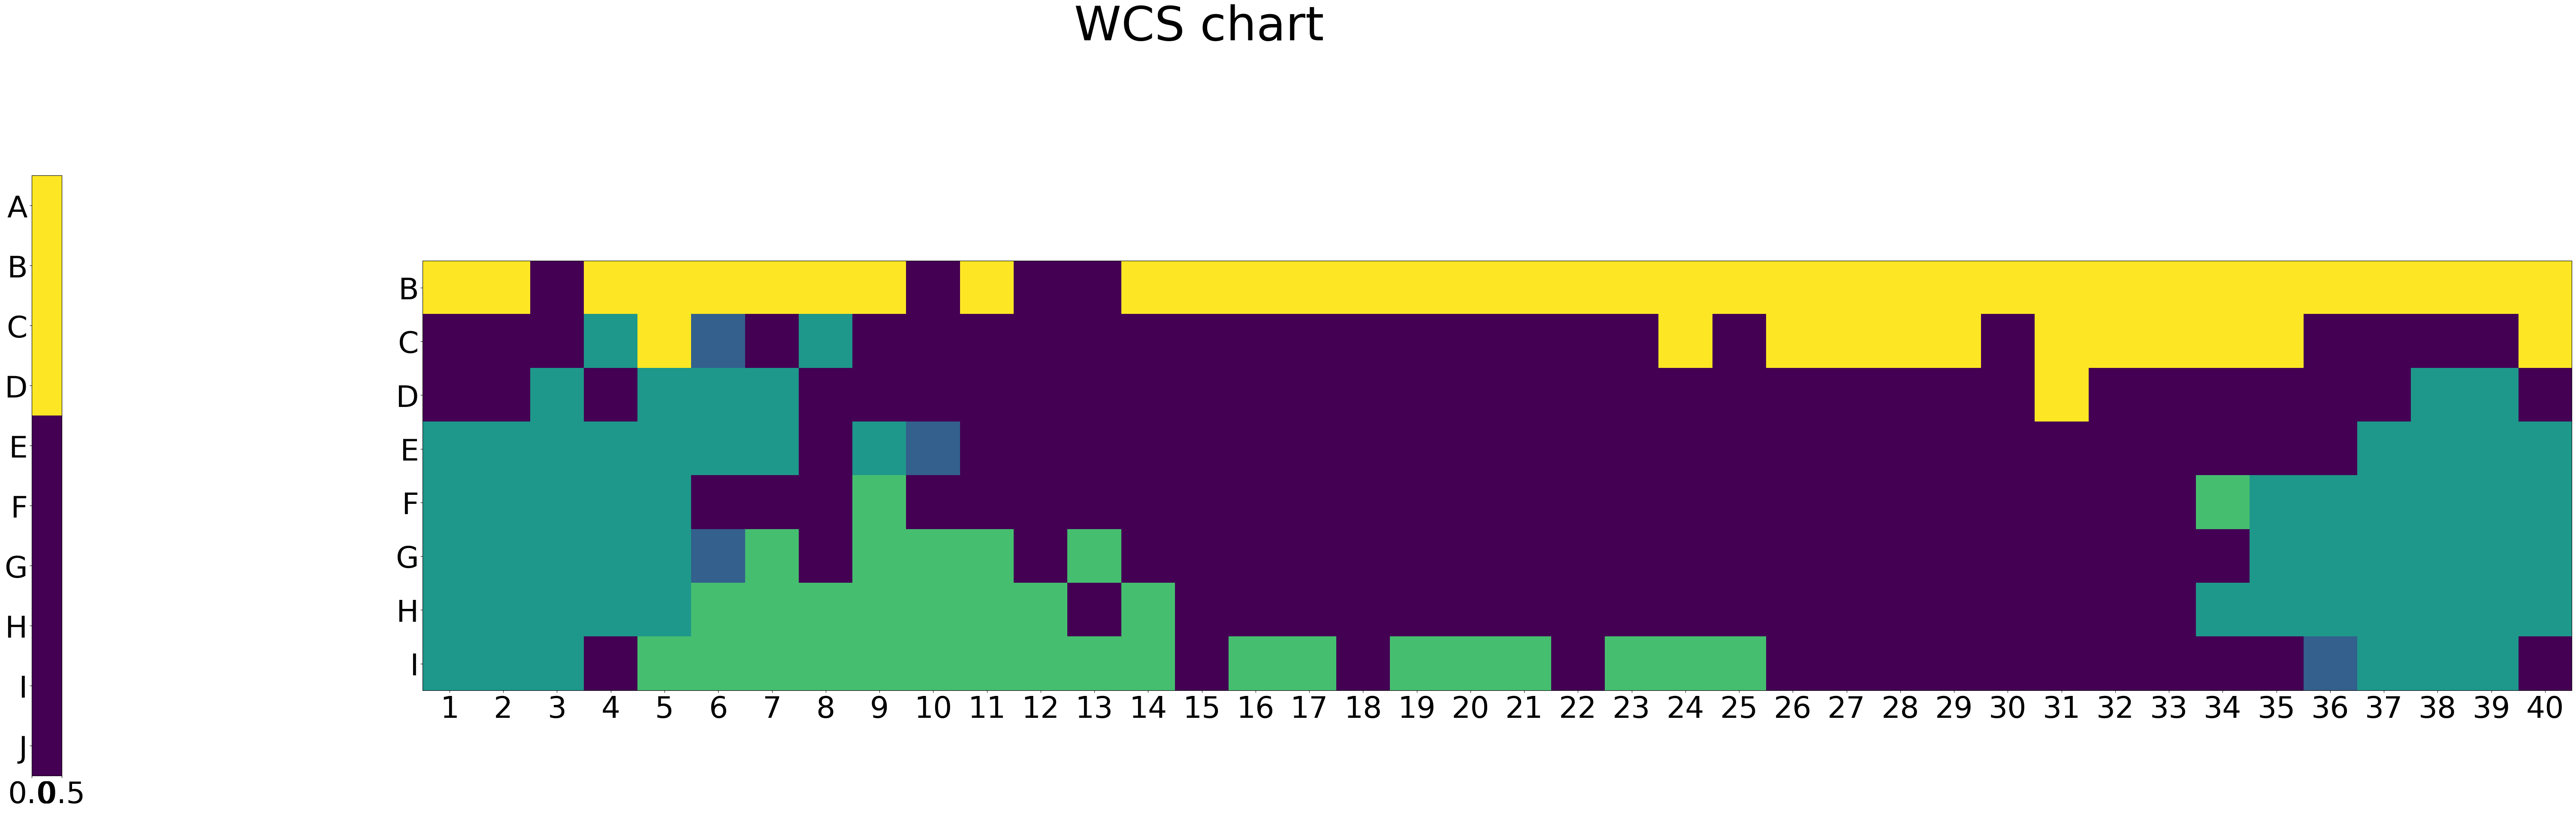

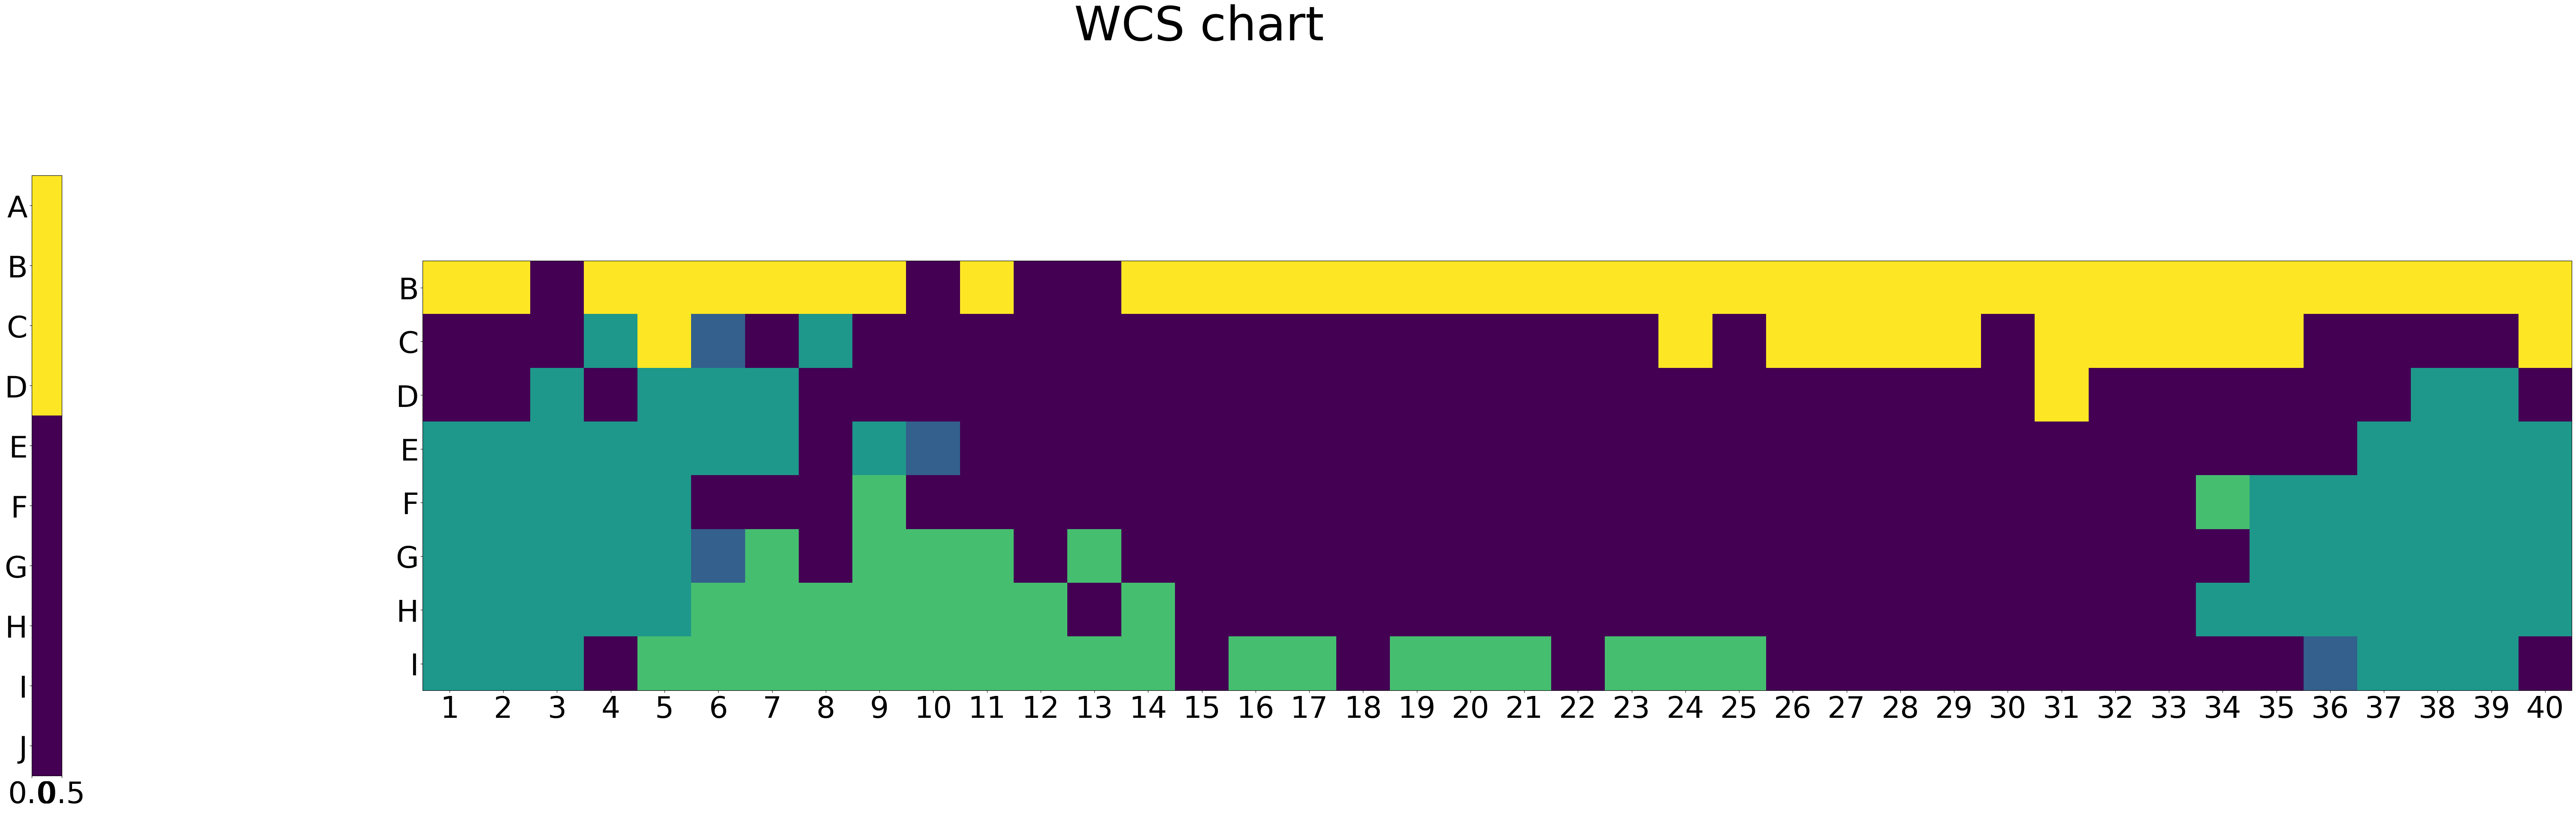

In [23]:
plotValues(encoded_terms)

**Note**: `plotValues()` is a generic function for visualizing various kinds of information on the chart, suited to needs.

Now you are in a position to start exploring this data set - enjoy!

## Our Analysis

### Empirical Color Foci

Our first goal is to reproduce the following diagram from Abbott, Griffiths, & Regier (2016) showing the empirical color foci from the WCS dataset.

![image.png](images/empirical-contours.png)

This graph shows the color chips that were most commonly identified as the focus of some color term across all languages. The clustering of the contours suggests a set of universal basic colors at each of the peaks in the contour plot.

Part of our evaluation of the prototype and exemplar models will be a qualitative comparison of their predicted color foci plots to this empirical one.

In [24]:
#fociData

In [25]:
overallFociCount = {}
for language in fociData:
    speakerData = fociData[language]
    for speaker in speakerData:
        colors = speakerData[speaker]
        for color in colors:
            colorFoci = colors[color]
            for focus in colorFoci:
                focusIndex = coordIndex[focus.replace(':', '')]
                if focusIndex in overallFociCount:
                    overallFociCount[focusIndex] += 1
                else:
                    overallFociCount[focusIndex] = 1


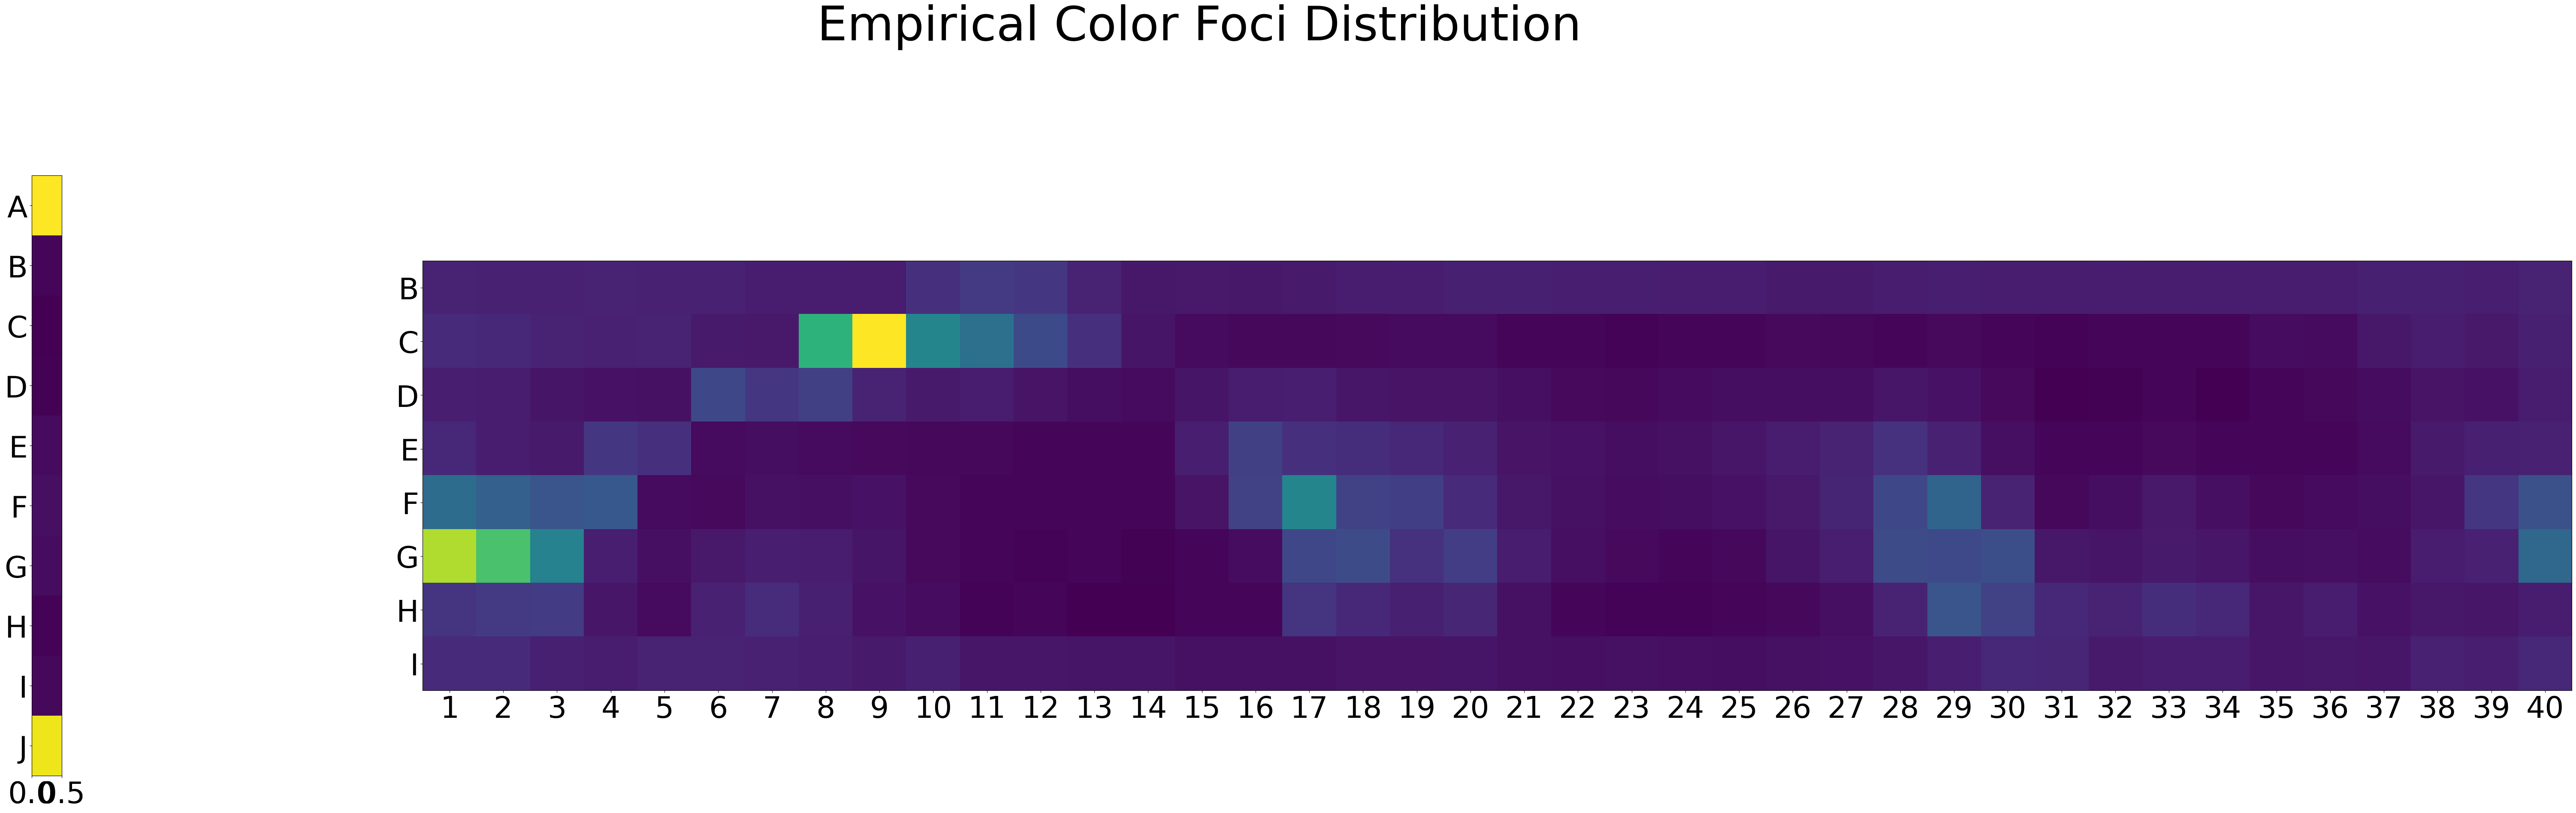

In [26]:
fig = plotValues(map_array_to(indexCoord, overallFociCount), title='Empirical Color Foci Distribution')

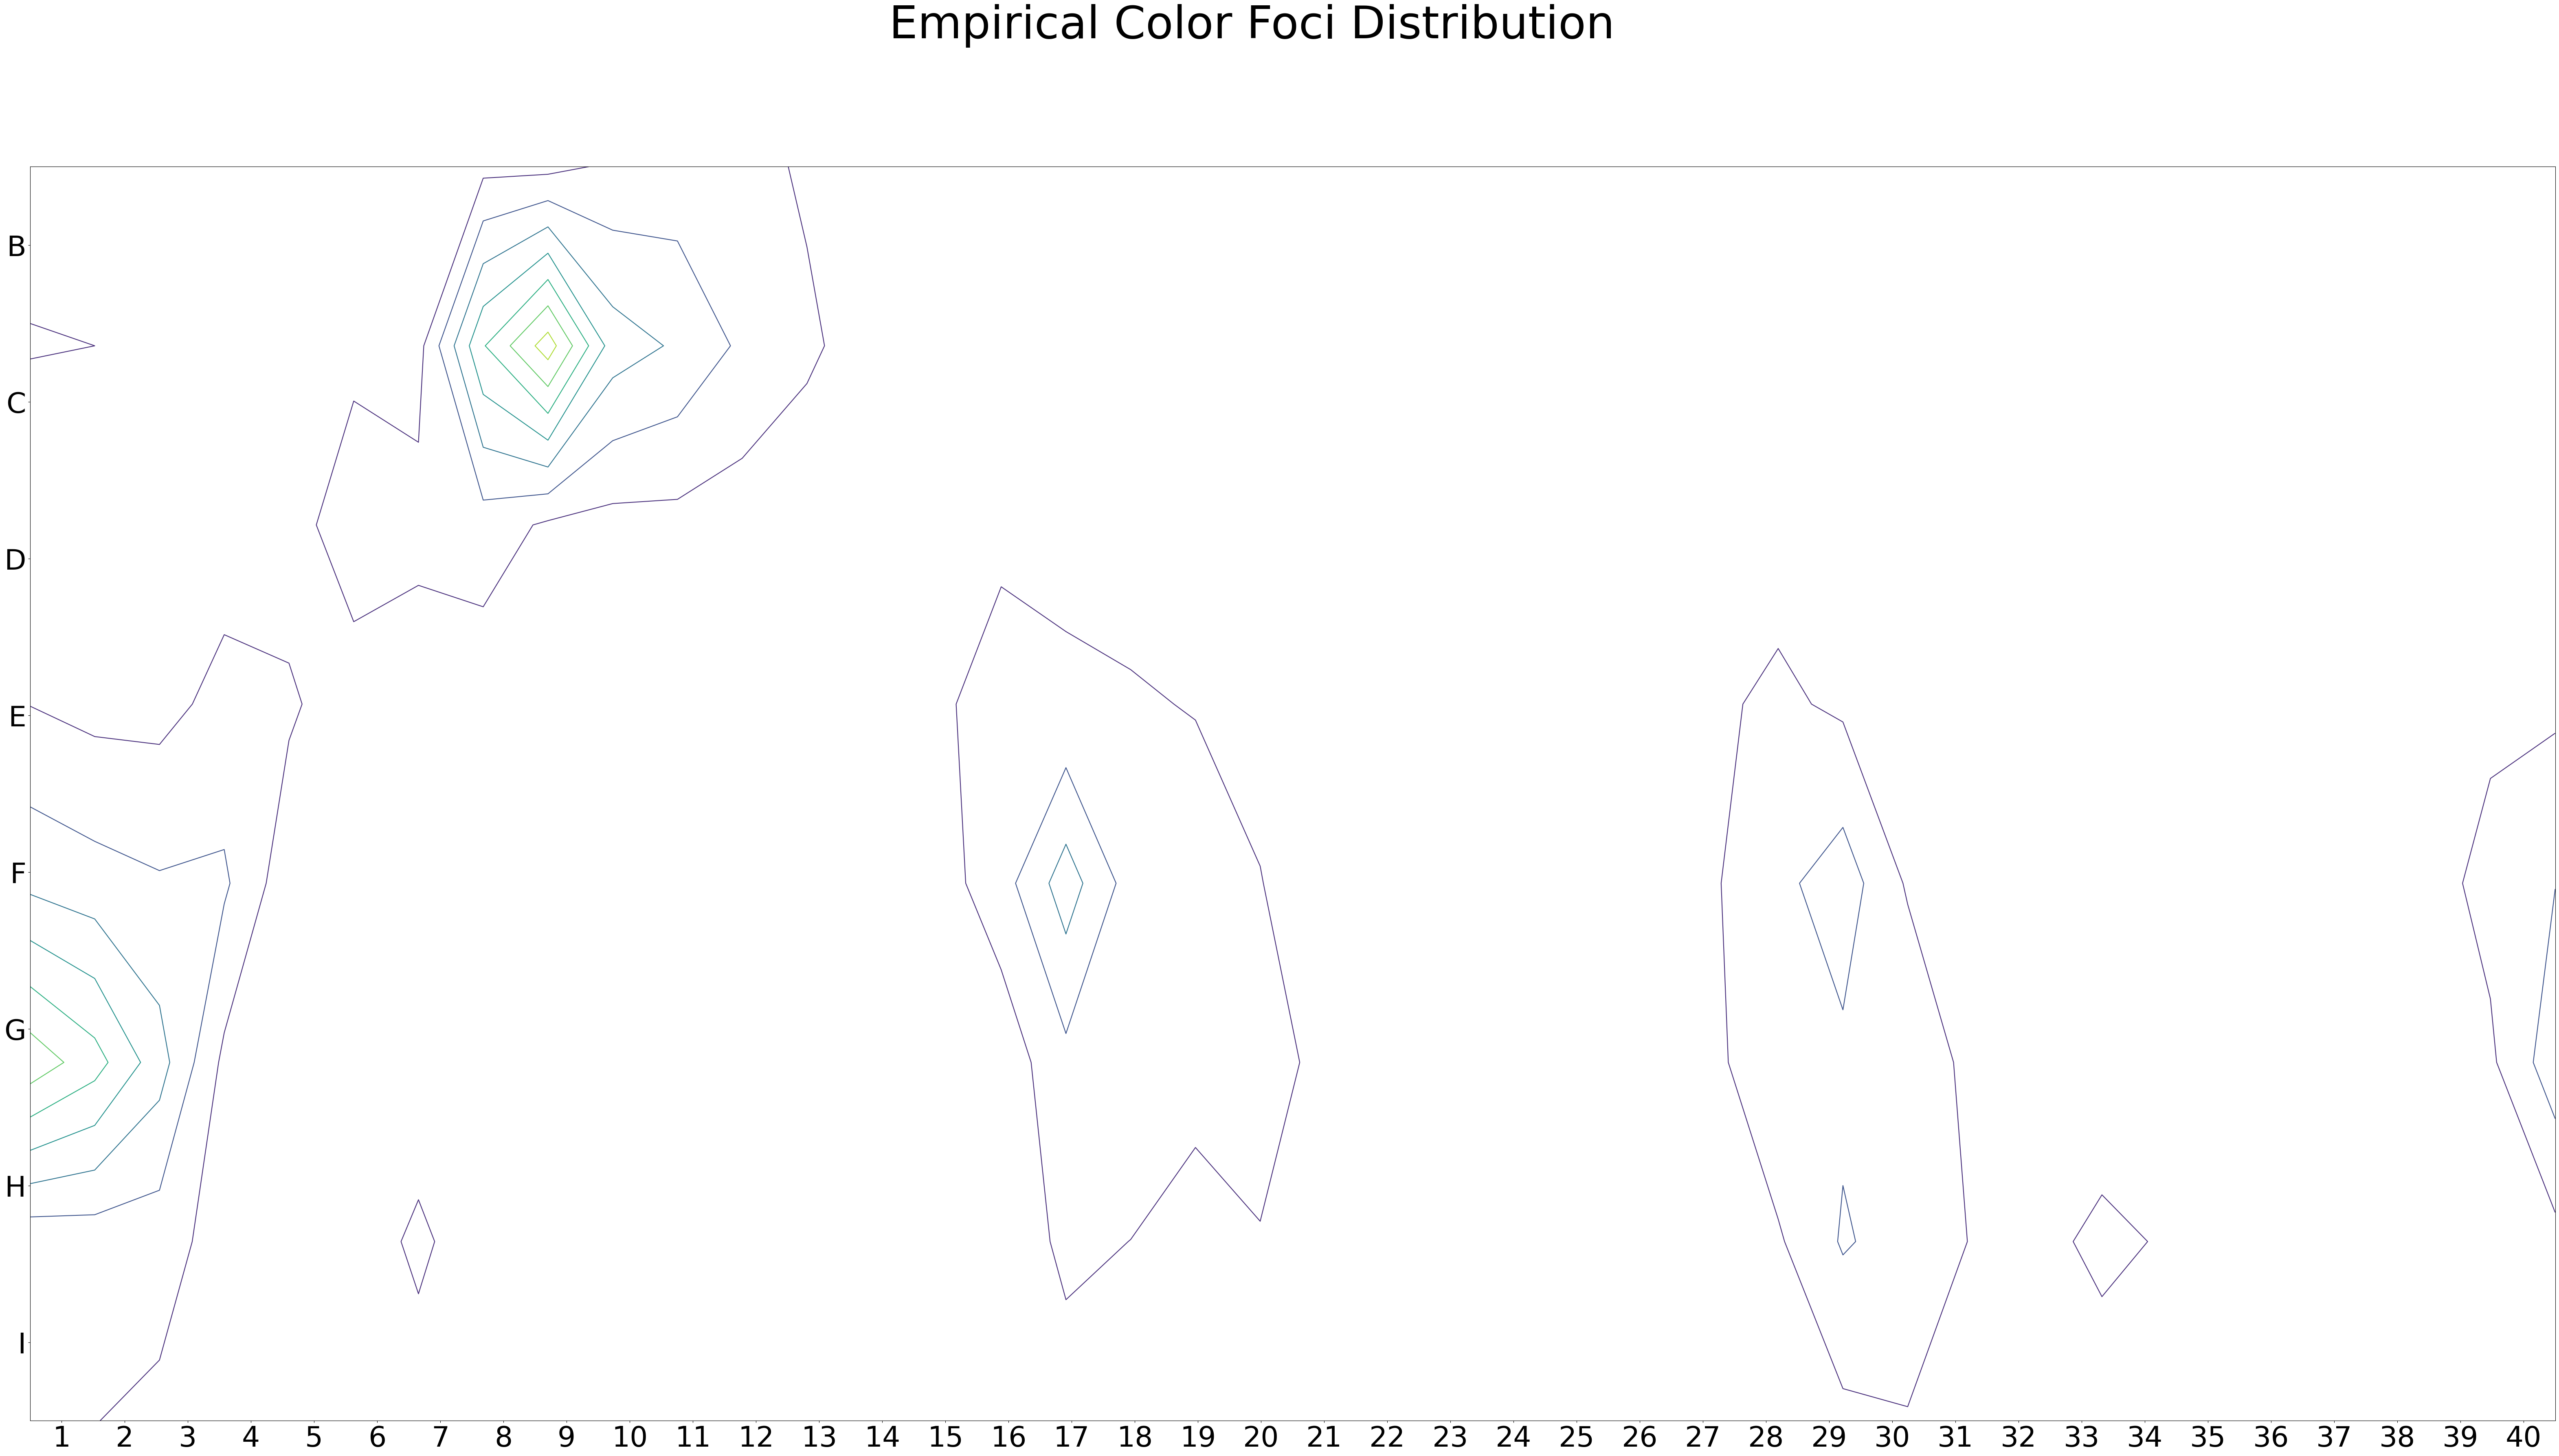

In [27]:
fig = plotValuesContour(map_array_to(indexCoord, overallFociCount), title='Empirical Color Foci Distribution')